# Informations

University of Zurich, <br>
Network Science, <br>
Assignment 7

Pietro Bonazzi, <br>
LEGI 17-200-635, <br>
pietro.bonazzi@uzh.ch

# Lib

In [1]:
%run functions.ipynb

In [3]:
folder="Data/7/Data/"
filenames=all_files(folder)
filenames.sort()
print(filenames)

['cormat_1h.npy', 'cormat_1m.npy', 'stocknames.txt']


In [4]:
cormat_h = np.load(folder+filenames[0])
cormat_m = np.load(folder+filenames[1])
data=[cormat_h,cormat_m]

with open(folder+filenames[2]) as file:
    lines = file.readlines()
    symbols = [line.rstrip() for line in lines]

# A07.1 - The Marčenko-Pastur law

Task: For the 97 most capitalized stocks in the NY Stock Exchange, filter the correlation matrix of returns at the 1 hour and 1 minute timescales using Marčenko-Pastur law
For each of the provided correlation matrices (for 1 hour and 1 minute returns):
+ compute the eigenvalues and eigenvectors
+ plot the histogram of eigenvalues and superimpose the Marčenko-Pastur law with parameter
  for hourly returns, 𝑄 = 3.6289, and for minute returns, 𝑄 = 200.8969
+ compute the denoised correlations (see lecture)

In [5]:
def compare_eigenvalue_distribution(corr, Q, title):
    
    def handle_neg(a):
        return np.maximum(a, np.zeros_like(a))
    
    #1 compute the eigenvalues and eigenvectors
    eigVal, eVect =np.linalg.eigh(corr)
    
    #2 plot the histogram of eigenvalues
    nn, bb, patches=plt.hist(eigVal.ravel(), bins="auto", density=True)    
        
    eigVal_max=1*(1+1/Q+2*np.sqrt(1/Q))
    eigVal_min=1*(1+1/Q-2*np.sqrt(1/Q)) 
    x = np.linspace(eigVal_min,eigVal_max,97)
    
    # superimpose the Marčenko-Pastur law
    dist=np.sqrt(handle_neg(eigVal_max-eigVal)*handle_neg(eigVal-eigVal_min))*Q/(2*np.pi*1)
    
    plt.ylabel("λ")
    plt.xlabel("p(λ)")
    plt.title(title+" returns")
    plt.plot(x, dist)
    plt.grid()
    plt.show()
    
    
    #3 compute the denoised correlations (see lecture)
    eigVal_Filt=eigVal
    for i in range (len(eigVal)):
        if eigVal_Filt[i]<eigVal_max :  #classify eigenvalues
            eigVal_Filt[i]=0 # replace noise with a constant

    #normalize
    norm=(len(eigVal_Filt)-sum(eigVal_Filt))/len(eigVal_Filt)
    for i in range (len(eigVal)):
        eigVal_Filt[i] += norm 
        
    temp =  np.dot(eVect, np.dot(np.diag(eigVal_Filt), np.transpose(eVect)))
    
    np.fill_diagonal(temp, 1)
    
    filtered_matrix = temp
    
    return filtered_matrix

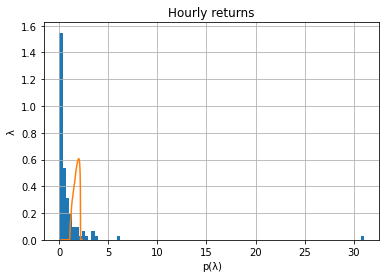

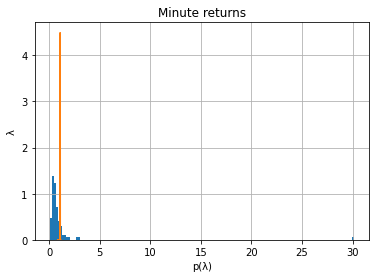

In [6]:
Q = [3.6289, 200.8969]
tit= ["Hourly", "Minute"]
denoised=[]

for i in range(len(Q)):
    denoised.append(compare_eigenvalue_distribution(data[i], Q[i], tit[i]))

# A07.2 - Correlation MSTs
Task: Build MSTs from denoised correlations and analyze them
+ make a scatterplot of the 1 hour vs 1 minute denoised correlations (1 data point per pair of stocks)
+ from the denoised correlation matrices, build the Minimum Spanning Tree (see lecture)
+ assign the correct ticker (’AAPL’, ’AMZN’, …) as an attribute to the nodes and calculate the degrees
+ make a scatterplot of the 1 hour vs 1 minute MST degrees of stocks (1 data point per stock)

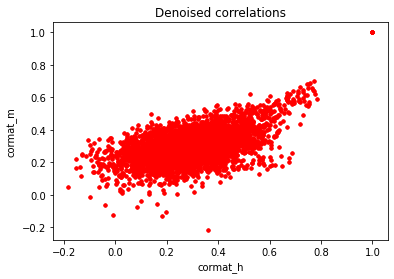

In [7]:
plot_scatter(denoised[0], denoised[1],"cormat_h", "cormat_m", "Denoised correlations")

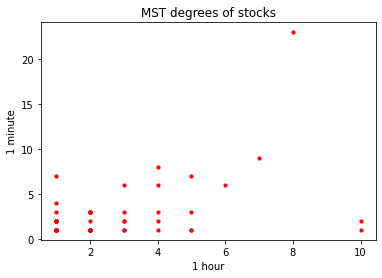

In [22]:
arr_distances_h=np.zeros((97,97))
arr_distances_m=np.zeros((97,97))

for i in range(97) :
    for j in range(97):
        arr_distances_h[i][j]=np.sqrt(2*(1-denoised[0][i][j]))
        arr_distances_m[i][j]=np.sqrt(2*(1-denoised[1][i][j]))
        
G_h=nx.from_numpy_matrix(arr_distances_h)
mst_h=nx.minimum_spanning_tree(G_h)
nx.set_node_attributes(mst_h, symbols, 'ticker')
deg_h=degree_vec(mst_h)

G_m=nx.from_numpy_matrix(arr_distances_m)
mst_m=nx.minimum_spanning_tree(G_m)
nx.set_node_attributes(mst_m, values=symbols, name='ticker')
deg_m=degree_vec(mst_m)

plot_scatter(deg_h, deg_m,"1 hour", "1 minute", "MST degrees of stocks")

# A07.3 - Conclusions
Task: finish the analysis by drawing conclusions

Answer the following questions (for both timescales):
1. Is there a ‘market mode’?

    Yes, it's around 30 for both timescales

2. Which is the stock that has the strongest relation with the market?

In [14]:
srm, srh=[], []
for i in range(97):
    srh.append(np.sum(denoised[0][i]))
    srm.append(np.sum(denoised[1][i]))

print("In minute returns")
idx=srm.index(min(srm))
print("Stock that has the strongest relation :", symbols[idx])

print("\n")

print("In hourly returns")
idx=srh.index(min(srh))
print("Stock that has the strongest relation :", symbols[idx])

In minute returns
Stock that has the strongest relation : MMM


In hourly returns
Stock that has the strongest relation : EXC


3. Which are the 5 stocks with highest degree on the MST?

In [23]:
print("In minute returns")
tmp_m=list(deg_m)
deg_m = sorted(np.unique(deg_m), reverse=True)
print("Degree distribution: ", deg_m)

top=0

for i in range(0,5) :
    max_m = np.where(tmp_m == deg_m[i])[0]
    for j in range(len(max_m)) :    
        print(i+1 ,": " + symbols[max_m[j]])
    
    if len(max_m)>1 :
        top+=len(max_m)-1

tmp_h=list(deg_h)
deg_h = sorted(np.unique(deg_h), reverse=True)

print("\n")
print("In hourly returns")
print("Degree distribution: ", deg_h)
top=0
for i in range(0,5) :
    max_h = np.where(tmp_h == deg_h[i])[0]
    for j in range(len(max_h)) :
        print(i+1 ,": " + symbols[max_h[j]])
        
    if len(max_h)>1 :
        top+=len(max_h)-1

In minute returns
Degree distribution:  [23, 9, 8, 7, 6, 4, 3, 2, 1]
1 : HON
2 : JPM
3 : EMR
4 : DIS
4 : MRK
5 : COP
5 : GD
5 : MET


In hourly returns
Degree distribution:  [10, 8, 7, 6, 5, 4, 3, 2, 1]
1 : GOOG
1 : MMM
2 : HON
3 : JPM
4 : COP
5 : APA
5 : DIS
5 : GS
5 : UNP


4. Is the degree distribution of MSTs qualitatively the same at 1 minute and 1 hour?  

    No

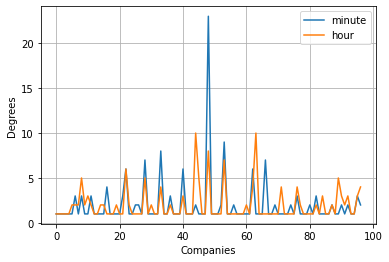

In [28]:
x=np.arange(0,97,1)
plt.plot(x, tmp_m, label="minute")
plt.plot(x, tmp_h, label="hour")
plt.xlabel("Companies")
plt.ylabel("Degrees")
plt.grid()
plt.legend()
plt.show()